# Libraries

In [1]:
import os
import numpy as np
from time import time
from scipy.io import wavfile as wav

import matplotlib.pyplot as plt
import IPython.display as ipd

# Classification tools
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# File management
#from google.colab import drive
import tarfile
from shutil import copyfile

# Advanced audio features
import librosa
import librosa.display as lid
from sklearn.preprocessing import scale

#audio playback
import sounddevice as sd

# Data loader

In [2]:
# Placecholder for feature extractor
def identity(input):
    return input

# Data loader
def load_data(feature_extractor=identity, normalize=False):

    labels = []
    features = []

    for f in sorted(os.listdir('./audio')):
        if f.endswith('.wav'):
            # Load file and compute the requested features
            _, signal = wav.read('./audio/' + f)
            cur_features = feature_extractor(signal)
            features.append(cur_features)

            # Classes
            label = f.split('_')[1]
            labels.append(label)

    # X: features, y: labels
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=1)

    if normalize:
        eps = 0.001
        X_train = np.array(X_train) 
        X_train_mean = X_train.mean(axis=0)
        X_train_std = X_train.std(axis=0)
        X_train = (X_train - X_train_mean + eps)/(X_train_std + eps)
        X_train = [row for row in X_train]

        X_test = [row for row in (np.array(X_test) - X_train_mean + eps)/(X_train_std + eps)]

    return X_train, X_test, y_train, y_test, X_train_mean, X_train_std 

In [3]:
#standard deviation function
def sdev(input):
    return np.std(input, keepdims=True)

In [4]:
#energy function
def energy(input):
    return np.sum((input*1.0)**2, keepdims=True)

In [5]:
#crop function
def crop(input, size=100):
    # Remove any values exceeding the given limit
    output = input[88200:min(size+88200, input.shape[0])]
    # Add null values (padding) in order to reach the requested size
    output = np.concatenate((output, np.zeros(size-output.shape[0])))
    return output

In [6]:
#signal absolute mean 
def aavg(input):
    return np.mean(np.abs(input), keepdims=True)

In [7]:
#zero crossing rate
def zcr(input):
  zcr = 0
  lista=[]
  for x in range(len(input)):
    try:
      z = x+1
      plu = input[z]
    except:
      pass
    else:
      #b = np.sign(input[x])
      c = np.sign(input[x] * plu)
      if np.sign(1) != c:
        #zcr = zcr +1
        lista.append(1)

      else:
        pass
      
  return np.sum(lista, keepdims=True)

In [8]:
#combo function
def combo(input):
    return np.concatenate((crop(input), sdev(input), aavg(input), energy(input), zcr(input)))

In [9]:
#feature and label
X_train, X_test, y_train, y_test, X_train_mean, X_train_std =load_data(feature_extractor=combo, normalize=True)

# Training

-------

In [10]:
# Parameters to be tested in cross-validation
param_grid = {'C': [1e2, 5e2, 1e3],
          'gamma': [0.005, 0.01, 0.1, 0.5, 1.0], }

In [11]:
# Support Vector Machine initialization
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

In [12]:
#fitting the model
clf = clf.fit(X_train, y_train)

In [13]:
# Result of the cross validation for parameters selection
print('Best parameters combination:')
print(' C: '+str(clf.best_estimator_.C))
print(' gamma: '+str(clf.best_estimator_.gamma))

Best parameters combination:
 C: 500.0
 gamma: 0.01


# Testing

In [14]:
#prediction on test data
y_pred = clf.predict(X_test)
y_pred

array(['mc', 'mc', 'cr', 'fm', 'mc', 'mc', 'cr', 'mc', 'mc', 'cr', 'mc',
       'mc', 'cr', 'cr', 'cr', 'cr', 'fm', 'cr', 'mc', 'mc', 'cr', 'cr',
       'mc', 'mc', 'mc', 'cr', 'cr', 'fm', 'mc', 'mc', 'mc', 'cr', 'cr',
       'fm', 'cr', 'cr', 'mc', 'mc', 'cr', 'cr', 'fm', 'mc', 'fm', 'mc',
       'mc'], dtype='<U2')

# Report

Classification report:
              precision    recall  f1-score   support

          cr       1.00      1.00      1.00        18
          fm       0.50      0.27      0.35        11
          mc       0.62      0.81      0.70        16

    accuracy                           0.76        45
   macro avg       0.71      0.70      0.69        45
weighted avg       0.74      0.76      0.74        45

Confusion matrix:
[[18  0  0]
 [ 0  3  8]
 [ 0  3 13]]


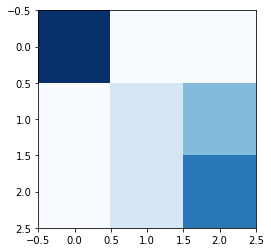

In [15]:
# Classification report
print('Classification report:')
print(classification_report(y_test, y_pred))

# Confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred)
print(cm)
plt.imshow(cm, cmap=plt.cm.Blues)

---

# Demo testing

In [16]:
#Recording parameters
duration = 5 # (seconds)
rec_rate = 44100

In [17]:
#preprocessing per i nuovi dati passati
def preprocess(input):
    rec = combo(input)
    eps = 0.001
    rec = (np.array(rec) - X_train_mean + eps)/(X_train_std + eps)

    return rec

## Riconoscimento altri componenti

In [51]:
#registrazione altri con diverso microfono rispetto a quello utilizzato per creare dataset training
for f in sorted(os.listdir('./fm_rec_nocuffie')):
        if f.endswith('.wav'):
            # Load file and compute the requested features
            _, signal = wav.read('./fm_rec_nocuffie/' + f)

In [52]:
# applicazione funzione preprocessing
signal = preprocess(signal)

In [53]:
#reshaping the signal
signal = signal.reshape(1,-1)

In [54]:
#class prediction
clf.predict(signal)

array(['fm'], dtype='<U2')

## Mio riconoscimento

In [40]:
#rec: per valutare se riconosce me
rec = sd.rec(int(duration * rec_rate), samplerate=rec_rate, channels=1, blocking=True)

In [41]:
#rec playback
ipd.Audio(rec[:,0], rate=rec_rate)

In [42]:
#prepare the signal to be preprocessed
rec_ready = rec.flatten()

In [43]:
#printing the obtained shape
rec_ready.shape

(220500,)

In [44]:
#applicazione preprocessing
rec_to_recog = preprocess(rec_ready)
rec_to_recog

array([-0.00532806, -0.03921514, -0.0684837 , -0.09332283, -0.11854678,
       -0.14821471, -0.18013403, -0.212802  , -0.24507688, -0.27685396,
       -0.30522968, -0.32777151, -0.34902265, -0.36962351, -0.39452409,
       -0.42316291, -0.45554383, -0.48938103, -0.52342029, -0.55271933,
       -0.5747782 , -0.58644986, -0.58902462, -0.58924351, -0.59180945,
       -0.60726921, -0.63320011, -0.66486078, -0.6941186 , -0.71529912,
       -0.724555  , -0.72656687, -0.72852404, -0.7326152 , -0.7358036 ,
       -0.73220668, -0.72069094, -0.70831943, -0.70348954, -0.71038806,
       -0.72388493, -0.7343035 , -0.73551278, -0.72512981, -0.70659017,
       -0.69122567, -0.6871824 , -0.69361953, -0.70179508, -0.70634996,
       -0.70385042, -0.69636028, -0.69544723, -0.70540447, -0.71465598,
       -0.70162381, -0.65844788, -0.59143207, -0.51677438, -0.45248524,
       -0.40570856, -0.37094476, -0.33547695, -0.29358309, -0.23992427,
       -0.18320204, -0.12711567, -0.07544886, -0.02734278,  0.01

In [45]:
#reshaping
rec_to_recog = rec_to_recog.reshape(1,-1)

In [46]:
#prediction on the new audio passed
clf.predict(rec_to_recog)

array(['cr'], dtype='<U2')

---